In [5]:
import matplotlib.pyplot as plt
import numpy as np

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_CMOS_PWFS_aug2022_3 import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


M2C_KL = compute_M2C(telescope            = tel, \
                     atmosphere         = atm, \
                     deformableMirror   = dm, \
                     param              = None, \
                     nameFolder         = None, \
                     nameFile           = None, \
                     remove_piston      = True, \
                     HHtName            = None, \
                     baseName           = None , \
                     mem_available      = 1e9, \
                     minimF             = False, \
                     nmo                = None, \
                     ortho_spm          = True, \
                     SZ                 = np.int64(2*tel.OPD.shape[0]), \
                     nZer               = 3, \
                     NDIVL              = 1, \
                     recompute_cov=True, \
                     save_output= False)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=4,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=2,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])



# wfs_unmod = TR_Pyramid(nSubap=param['nSubaperture'], \
#                  telescope=tel, \
#                  modulation=0, \
#                  lightRatio=param['lightThreshold'], \
#                  n_pix_separation=4,
#                  calibModulation=param['calibrationModulation'], \
#                  psfCentering=param['psfCentering'], \
#                  n_pix_edge=2,
#                  extraModulationFactor=param['extraModulationFactor'], \
#                  postProcessing=param['postProcessing'],
#                  nTheta_user_defined = param['nTheta_user_defined'])

Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             24               [m]        
    Resolution           120             [pixels]     
    Pixel Size           0.2               [m]        
     Surface            452.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      11304            [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Source Wavelength Zenith  Azimuth   Altitude Magnitude    Flux   
           [m]    [arcsec]  [deg]      [m]              [phot/m2/s]
-------------------------------------------------------------------
  NGS    7.9e-07     0        0        inf       1.0    29208950

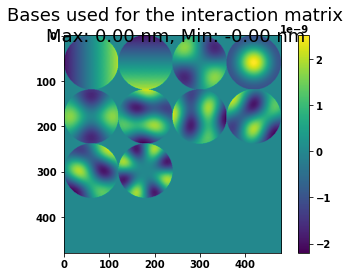

In [6]:
dm.coefs = M2C_KL[:, 0:10] * 1e-9
tel * dm * wfs
displayMap(tel.OPD)

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


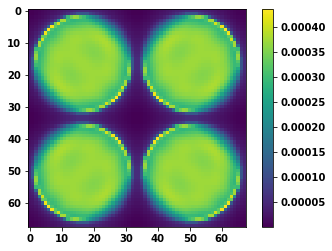

In [7]:
dm.coefs = 0
wfs.modulation = param["modulation"]
tel * dm * wfs
im = plt.imshow(wfs.referenceSignal_2D)
im1_cbar = plt.colorbar(im)

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 0, 'KL mode')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


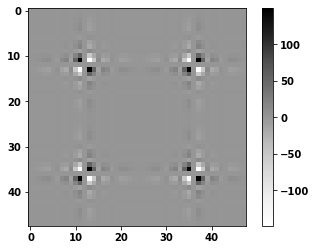

<Figure size 432x288 with 0 Axes>

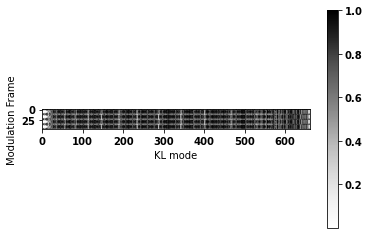

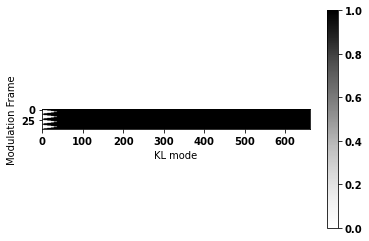

In [8]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9

i_cube = np.zeros((wfs.nTheta, np.sum(wfs.validSignal), nModes))
# ngs.nPhoton = 10000000000
wfs.modulation = param['modulation']
dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube[:, wfs.validSignal]
#ref_cube_c = np.zeros((ref_cube.shape[0], nModes))
#push_cube_c = np.zeros((ref_cube.shape[0], nModes))
#pull_cube_c = np.zeros((ref_cube.shape[0], nModes))
#to_cov = np.zeros(())
# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)
for i in range(nModes):

    #t = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))
    #ref_cube_c[:,i] = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))/stroke
    dm.coefs = M2C_KL[:, i] * stroke
    tel * dm * wfs
    push = wfs.cam.cube[:, wfs.validSignal]
    push_signal = push/np.sum(push) - \
                      ref_cube/np.sum(ref_cube)

    #push_cube_c[:,i] = np.sqrt(np.mean((push/np.sum(push))**2, axis=1))/stroke
    if i == 0:
        push_cube_c = np.mean(push_signal, axis=1)/stroke

    dm.coefs = -M2C_KL[:, i] * stroke
    tel * dm * wfs
    pull = wfs.cam.cube[:, wfs.validSignal]
    pull_signal = pull/np.sum(pull) - \
                      ref_cube/np.sum(ref_cube)
    if i == 0:
        pull_cube_c = np.mean(pull_signal, axis=1)/stroke

    i_cube[:,:,i] = (0.5 * (push_signal - pull_signal) / stroke)

plt.figure()

t = np.zeros((48,2))
t[:,0] = push_cube_c
t[:,1] = pull_cube_c
cov_ref_push = np.cov(t)
im_cov_push = plt.imshow(cov_ref_push, cmap=cm.Greys)
im_cov_push_cbar = plt.colorbar(im_cov_push)

plt.figure()
weighting_cube = np.zeros((wfs.nTheta, nModes))
for i in range(nModes):
    #weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    avg_val = np.mean(i_cube[:, :, i])
    #avg_val = 0
    weighting_cube[:,i] = ((np.mean((i_cube[:, :, i]-avg_val)**2, axis=1)))**2
    #weighting_cube[:,i] = -(weighting_cube[:,i] - np.mean(weighting_cube[:,i]))
    weighting_cube[:,i] = weighting_cube[:,i]  / np.max(np.abs(weighting_cube[:,i]))

    #weighting_cube[:,i] = np.arctan(weighting_cube[:,i])

plt.figure()
im = plt.imshow(weighting_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")
plt.figure()
# binary_weight_cube = np.copy(weighting_cube)
# threshold = 0.5
# binary_weight_cube[weighting_cube < threshold] = 0
# binary_weight_cube[weighting_cube >= threshold] = 1

framesRemPerFace = [11, 11, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                                      3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
binary_weight_cube = np.ones((wfs.nTheta, nModes))
for f in range(len(framesRemPerFace)):
    idx = calcEquidistantFrameIndices(framesRemPerFace[f], wfs.nTheta)
    binary_weight_cube[idx, f] = 0


im = plt.imshow(binary_weight_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")

In [9]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9


def getInterationMatrixModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube[:, wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.cube[:, wfs.validSignal]
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.cube[:, wfs.validSignal]
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )
    return imat

def getInterationMatrixUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = wfs.cam.frame[wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.frame[wfs.validSignal]
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.frame[wfs.validSignal]
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)


        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )

    return imat

I_mat_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
I_mat_unmodulated = getInterationMatrixUnmodulated()
I_mat_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
I_mat_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])


I_mat_modulated_inv = inv(I_mat_modulated.T @ I_mat_modulated) @ I_mat_modulated.T
I_mat_unmodulated_inv = inv(I_mat_unmodulated.T @ I_mat_unmodulated) @ I_mat_unmodulated.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T
I_mat_binary_inv = inv(I_mat_binary.T @ I_mat_binary) @ I_mat_binary.T


Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


# Finally, with the interaction matrix, we should be able the calculate the sensitivity of the system.
This is the part I struggle with, I am usure why I don't get values between 0 and 2 like in the litterature. Here I'm following formula 3.11 from Chambouleyron's thesis.

$$ s_b (\phi_i) = \| \delta I(\phi_i) \|_2   $$

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


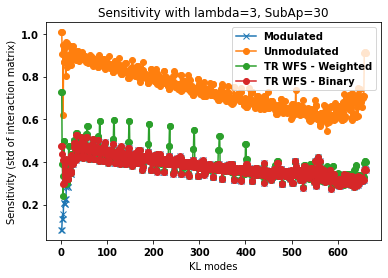

In [10]:
radian_in_1m = (2*np.pi)/ ngs.wavelength
plt.figure()
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_modulated)**2, axis=0)) / radian_in_1m, marker="x",label="Modulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_unmodulated - np.mean(I_mat_modulated, axis=0) )**2, axis=0)) / radian_in_1m, marker="o",label="Unmodulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_weighted )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_binary )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}, SubAp={wfs.nSubap}")
plt.legend()

Telescope and Atmosphere combined!


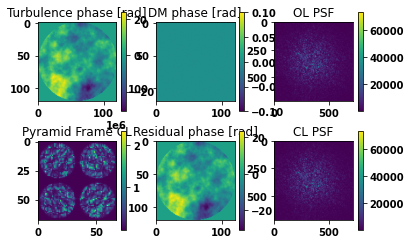

Elapsed time: 0.27800512313842773 s


<Figure size 432x288 with 0 Axes>

Loop0/100 Turbulence: 1102.8653577396194 -- Residual:1102.8653577396194

Elapsed time: 0.2929267883300781 s


<Figure size 432x288 with 0 Axes>

Loop1/100 Turbulence: 1103.0885469438338 -- Residual:1103.0885469438338

Elapsed time: 0.2767961025238037 s


<Figure size 432x288 with 0 Axes>

Loop2/100 Turbulence: 1103.2896594049453 -- Residual:1021.5161529477522

Elapsed time: 0.27162957191467285 s


<Figure size 432x288 with 0 Axes>

Loop3/100 Turbulence: 1103.4762400702584 -- Residual:941.9825196717728

Elapsed time: 0.26210498809814453 s


<Figure size 432x288 with 0 Axes>

Loop4/100 Turbulence: 1103.6818457911086 -- Residual:860.8134077646633

Elapsed time: 0.2629709243774414 s


<Figure size 432x288 with 0 Axes>

Loop5/100 Turbulence: 1103.8828522822942 -- Residual:780.1918512687085

Elapsed time: 0.27622270584106445 s


<Figure size 432x288 with 0 Axes>

Loop6/100 Turbulence: 1104.0847161057773 -- Residual:704.0338203952667

Elapsed time: 0.27240967750549316 s


<Figure size 432x288 with 0 Axes>

Loop7/100 Turbulence: 1104.2921476932524 -- Residual:633.3724477260786

Elapsed time: 0.2718832492828369 s


<Figure size 432x288 with 0 Axes>

Loop8/100 Turbulence: 1104.5088332183968 -- Residual:567.6532893045955

Elapsed time: 0.2833399772644043 s


<Figure size 432x288 with 0 Axes>

Loop9/100 Turbulence: 1104.7376374669325 -- Residual:507.17707205876064

Elapsed time: 0.25409913063049316 s


<Figure size 432x288 with 0 Axes>

Loop10/100 Turbulence: 1104.980251446478 -- Residual:452.8277958270081

Elapsed time: 0.29274535179138184 s


<Figure size 432x288 with 0 Axes>

Loop11/100 Turbulence: 1105.2372182567897 -- Residual:404.4881953706644

Elapsed time: 0.2623789310455322 s


<Figure size 432x288 with 0 Axes>

Loop12/100 Turbulence: 1105.5075797739328 -- Residual:361.26764377131803

Elapsed time: 0.26899027824401855 s


<Figure size 432x288 with 0 Axes>

Loop13/100 Turbulence: 1105.8371898881107 -- Residual:322.8744510691794

Elapsed time: 0.2760145664215088 s


<Figure size 432x288 with 0 Axes>

Loop14/100 Turbulence: 1106.1376751232442 -- Residual:288.9514171048024

Elapsed time: 0.2788224220275879 s


<Figure size 432x288 with 0 Axes>

Loop15/100 Turbulence: 1106.4453966320193 -- Residual:259.2598335348208

Elapsed time: 0.27632951736450195 s


<Figure size 432x288 with 0 Axes>

Loop16/100 Turbulence: 1106.7560271586901 -- Residual:233.6947685745458

Elapsed time: 0.24692916870117188 s


<Figure size 432x288 with 0 Axes>

Loop17/100 Turbulence: 1107.0644044212945 -- Residual:212.13253644280016

Elapsed time: 0.2569708824157715 s


<Figure size 432x288 with 0 Axes>

Loop18/100 Turbulence: 1107.3649226791279 -- Residual:194.35343394368113

Elapsed time: 0.2511312961578369 s


<Figure size 432x288 with 0 Axes>

Loop19/100 Turbulence: 1107.6508550665865 -- Residual:180.19113118080904

Elapsed time: 0.29770803451538086 s


<Figure size 432x288 with 0 Axes>

Loop20/100 Turbulence: 1107.9190512599032 -- Residual:169.61838776377024

Elapsed time: 0.29408931732177734 s


<Figure size 432x288 with 0 Axes>

Loop21/100 Turbulence: 1108.1339192145572 -- Residual:162.19881328354984

Elapsed time: 0.2852160930633545 s


<Figure size 432x288 with 0 Axes>

Loop22/100 Turbulence: 1108.3631798523586 -- Residual:157.07646207766498

Elapsed time: 0.2768239974975586 s


<Figure size 432x288 with 0 Axes>

Loop23/100 Turbulence: 1108.5787111237564 -- Residual:153.29056000263395

Elapsed time: 0.2523181438446045 s


<Figure size 432x288 with 0 Axes>

Loop24/100 Turbulence: 1108.7845110079784 -- Residual:150.3972526408778

Elapsed time: 0.28954458236694336 s


<Figure size 432x288 with 0 Axes>

Loop25/100 Turbulence: 1108.9841142962568 -- Residual:148.17350831978808

Elapsed time: 0.28498363494873047 s


<Figure size 432x288 with 0 Axes>

Loop26/100 Turbulence: 1109.1809274681634 -- Residual:146.48929995071794

Elapsed time: 0.26238417625427246 s


<Figure size 432x288 with 0 Axes>

Loop27/100 Turbulence: 1109.3778321723373 -- Residual:145.229328471151

Elapsed time: 0.2572355270385742 s


<Figure size 432x288 with 0 Axes>

Loop28/100 Turbulence: 1109.604351654245 -- Residual:144.28521648672046

Elapsed time: 0.27769923210144043 s


<Figure size 432x288 with 0 Axes>

Loop29/100 Turbulence: 1109.846340485047 -- Residual:143.61816791735777

Elapsed time: 0.2554662227630615 s


<Figure size 432x288 with 0 Axes>

Loop30/100 Turbulence: 1110.1034446627211 -- Residual:143.16457306273142

Elapsed time: 0.261030912399292 s


<Figure size 432x288 with 0 Axes>

Loop31/100 Turbulence: 1110.3772796078763 -- Residual:142.9032261577787

Elapsed time: 0.2641146183013916 s


<Figure size 432x288 with 0 Axes>

Loop32/100 Turbulence: 1110.6680834963684 -- Residual:142.7937040988857

Elapsed time: 0.2706296443939209 s


<Figure size 432x288 with 0 Axes>

Loop33/100 Turbulence: 1110.9753552335928 -- Residual:142.84224700136423

Elapsed time: 0.2693662643432617 s


<Figure size 432x288 with 0 Axes>

Loop34/100 Turbulence: 1111.297171355971 -- Residual:143.024953332605

Elapsed time: 0.25635671615600586 s


<Figure size 432x288 with 0 Axes>

Loop35/100 Turbulence: 1111.6304844451552 -- Residual:143.32614394454825

Elapsed time: 0.2446761131286621 s


<Figure size 432x288 with 0 Axes>

Loop36/100 Turbulence: 1111.9711148968179 -- Residual:143.73120170620098

Elapsed time: 0.2684352397918701 s


<Figure size 432x288 with 0 Axes>

Loop37/100 Turbulence: 1112.3143327971657 -- Residual:144.2117605373346

Elapsed time: 0.27530479431152344 s


<Figure size 432x288 with 0 Axes>

Loop38/100 Turbulence: 1112.6549491582823 -- Residual:144.72796982088127

Elapsed time: 0.27277278900146484 s


<Figure size 432x288 with 0 Axes>

Loop39/100 Turbulence: 1112.987888036977 -- Residual:145.24838964982976

Elapsed time: 0.25692248344421387 s


<Figure size 432x288 with 0 Axes>

Loop40/100 Turbulence: 1113.3104753548184 -- Residual:145.74023741593172

Elapsed time: 0.25625109672546387 s


<Figure size 432x288 with 0 Axes>

Loop41/100 Turbulence: 1113.6208295519039 -- Residual:146.1690890446556

Elapsed time: 0.2623109817504883 s


<Figure size 432x288 with 0 Axes>

Loop42/100 Turbulence: 1113.9658548812488 -- Residual:146.34947331019507

Elapsed time: 0.2772083282470703 s


<Figure size 432x288 with 0 Axes>

Loop43/100 Turbulence: 1114.2512195791187 -- Residual:146.5788827639085

Elapsed time: 0.26323509216308594 s


<Figure size 432x288 with 0 Axes>

Loop44/100 Turbulence: 1114.537061771834 -- Residual:146.7581129961899

Elapsed time: 0.2728271484375 s


<Figure size 432x288 with 0 Axes>

Loop45/100 Turbulence: 1114.818153214118 -- Residual:146.86106169257465

Elapsed time: 0.2779808044433594 s


<Figure size 432x288 with 0 Axes>

Loop46/100 Turbulence: 1115.09774905829 -- Residual:146.87341543802455

Elapsed time: 0.26584458351135254 s


<Figure size 432x288 with 0 Axes>

Loop47/100 Turbulence: 1115.3266848885546 -- Residual:146.939958473889

Elapsed time: 0.2590293884277344 s


<Figure size 432x288 with 0 Axes>

Loop48/100 Turbulence: 1115.60781796358 -- Residual:146.80469041723342

Elapsed time: 0.25975799560546875 s


<Figure size 432x288 with 0 Axes>

Loop49/100 Turbulence: 1115.8923487083637 -- Residual:146.5842743434854

Elapsed time: 0.27608466148376465 s


<Figure size 432x288 with 0 Axes>

Loop50/100 Turbulence: 1116.1797879983328 -- Residual:146.3899816082613

Elapsed time: 0.25884580612182617 s


<Figure size 432x288 with 0 Axes>

Loop51/100 Turbulence: 1116.4692888055465 -- Residual:146.24910099027124

Elapsed time: 0.2749478816986084 s


<Figure size 432x288 with 0 Axes>

Loop52/100 Turbulence: 1116.759693887251 -- Residual:146.16268397264403

Elapsed time: 0.2774355411529541 s


<Figure size 432x288 with 0 Axes>

Loop53/100 Turbulence: 1117.0701354830326 -- Residual:146.12696702630325

Elapsed time: 0.28063488006591797 s


<Figure size 432x288 with 0 Axes>

Loop54/100 Turbulence: 1117.3872290772829 -- Residual:146.12080526427124

Elapsed time: 0.2606165409088135 s


<Figure size 432x288 with 0 Axes>

Loop55/100 Turbulence: 1117.7079584254905 -- Residual:146.14965952267545

Elapsed time: 0.26478147506713867 s


<Figure size 432x288 with 0 Axes>

Loop56/100 Turbulence: 1118.0310181738405 -- Residual:146.17130352438326

Elapsed time: 0.2647716999053955 s


<Figure size 432x288 with 0 Axes>

Loop57/100 Turbulence: 1118.3544745691622 -- Residual:146.15907598483633

Elapsed time: 0.2686460018157959 s


<Figure size 432x288 with 0 Axes>

Loop58/100 Turbulence: 1118.6753795015895 -- Residual:146.06826548722918

Elapsed time: 0.258880615234375 s


<Figure size 432x288 with 0 Axes>

Loop59/100 Turbulence: 1118.9893046269544 -- Residual:145.86701181410905

Elapsed time: 0.2493288516998291 s


<Figure size 432x288 with 0 Axes>

Loop60/100 Turbulence: 1119.2992121554284 -- Residual:145.5409639293637

Elapsed time: 0.2589850425720215 s


<Figure size 432x288 with 0 Axes>

Loop61/100 Turbulence: 1119.6044908499878 -- Residual:145.08743561051207

Elapsed time: 0.2833397388458252 s


<Figure size 432x288 with 0 Axes>

Loop62/100 Turbulence: 1119.905964030128 -- Residual:144.5199838031744

Elapsed time: 0.2959768772125244 s


<Figure size 432x288 with 0 Axes>

Loop63/100 Turbulence: 1120.2187054466 -- Residual:143.84904325766962

Elapsed time: 0.27092552185058594 s


<Figure size 432x288 with 0 Axes>

Loop64/100 Turbulence: 1120.52104217618 -- Residual:143.144944383896

Elapsed time: 0.2480928897857666 s


<Figure size 432x288 with 0 Axes>

Loop65/100 Turbulence: 1120.8307972237546 -- Residual:142.47535616738398

Elapsed time: 0.35010409355163574 s


<Figure size 432x288 with 0 Axes>

Loop66/100 Turbulence: 1121.1530283471268 -- Residual:141.91511775443848

Elapsed time: 0.29280924797058105 s


<Figure size 432x288 with 0 Axes>

Loop67/100 Turbulence: 1121.491054423267 -- Residual:141.53903563438027

Elapsed time: 0.28014183044433594 s


<Figure size 432x288 with 0 Axes>

Loop68/100 Turbulence: 1121.8487890783192 -- Residual:141.40242166019084

Elapsed time: 0.26970553398132324 s


<Figure size 432x288 with 0 Axes>

Loop69/100 Turbulence: 1122.2282717847356 -- Residual:141.52791479940353

Elapsed time: 0.30935072898864746 s


<Figure size 432x288 with 0 Axes>

Loop70/100 Turbulence: 1122.6299268297278 -- Residual:141.90729318081247

Elapsed time: 0.25635457038879395 s


<Figure size 432x288 with 0 Axes>

Loop71/100 Turbulence: 1123.0529034441342 -- Residual:142.51190035363777

Elapsed time: 0.3043651580810547 s


<Figure size 432x288 with 0 Axes>

Loop72/100 Turbulence: 1123.4948985130677 -- Residual:143.28883856194798

Elapsed time: 0.274794340133667 s


<Figure size 432x288 with 0 Axes>

Loop73/100 Turbulence: 1123.9521715918354 -- Residual:144.14860493366012

Elapsed time: 0.27533960342407227 s


<Figure size 432x288 with 0 Axes>

Loop74/100 Turbulence: 1124.4197142100777 -- Residual:145.01773232353167

Elapsed time: 0.39847517013549805 s


<Figure size 432x288 with 0 Axes>

Loop75/100 Turbulence: 1124.891415271394 -- Residual:145.83758431907387

Elapsed time: 0.2927887439727783 s


<Figure size 432x288 with 0 Axes>

Loop76/100 Turbulence: 1125.360247961095 -- Residual:146.5242522806806

Elapsed time: 0.2531430721282959 s


<Figure size 432x288 with 0 Axes>

Loop77/100 Turbulence: 1125.8739215760659 -- Residual:147.05976828727256

Elapsed time: 0.28086137771606445 s


<Figure size 432x288 with 0 Axes>

Loop78/100 Turbulence: 1126.3381583855837 -- Residual:147.38372751758416

Elapsed time: 0.25797533988952637 s


<Figure size 432x288 with 0 Axes>

Loop79/100 Turbulence: 1126.7788884629583 -- Residual:147.43552134095512

Elapsed time: 0.26694273948669434 s


<Figure size 432x288 with 0 Axes>

Loop80/100 Turbulence: 1127.2014181588688 -- Residual:147.27739139120825

Elapsed time: 0.26769208908081055 s


<Figure size 432x288 with 0 Axes>

Loop81/100 Turbulence: 1127.605144895163 -- Residual:146.90956740325626

Elapsed time: 0.2689957618713379 s


<Figure size 432x288 with 0 Axes>

Loop82/100 Turbulence: 1127.996701271007 -- Residual:146.32959204326167

Elapsed time: 0.258098840713501 s


<Figure size 432x288 with 0 Axes>

Loop83/100 Turbulence: 1128.3745648321196 -- Residual:145.54234125745262

Elapsed time: 0.27840495109558105 s


<Figure size 432x288 with 0 Axes>

Loop84/100 Turbulence: 1128.7128362418798 -- Residual:144.5825382505167

Elapsed time: 0.24976444244384766 s


<Figure size 432x288 with 0 Axes>

Loop85/100 Turbulence: 1129.0763526728272 -- Residual:143.48003000610393

Elapsed time: 0.2828695774078369 s


<Figure size 432x288 with 0 Axes>

Loop86/100 Turbulence: 1129.4424022932242 -- Residual:142.2780408781816

Elapsed time: 0.24631452560424805 s


<Figure size 432x288 with 0 Axes>

Loop87/100 Turbulence: 1129.8172063419331 -- Residual:141.05640806562386

Elapsed time: 0.2718930244445801 s


<Figure size 432x288 with 0 Axes>

Loop88/100 Turbulence: 1130.206101711458 -- Residual:139.88553491275437

Elapsed time: 0.27907252311706543 s


<Figure size 432x288 with 0 Axes>

Loop89/100 Turbulence: 1130.6133889205234 -- Residual:138.8408858181283

Elapsed time: 0.2730731964111328 s


<Figure size 432x288 with 0 Axes>

Loop90/100 Turbulence: 1131.0421835613354 -- Residual:137.98402768229374

Elapsed time: 0.2570796012878418 s


<Figure size 432x288 with 0 Axes>

Loop91/100 Turbulence: 1131.4943752952545 -- Residual:137.36258631705473

Elapsed time: 0.2659134864807129 s


<Figure size 432x288 with 0 Axes>

Loop92/100 Turbulence: 1131.9705760116221 -- Residual:137.0082844507996

Elapsed time: 0.2508730888366699 s


<Figure size 432x288 with 0 Axes>

Loop93/100 Turbulence: 1132.47010293365 -- Residual:136.91174803472097

Elapsed time: 0.2590210437774658 s


<Figure size 432x288 with 0 Axes>

Loop94/100 Turbulence: 1132.9910841963433 -- Residual:137.06997522631792

Elapsed time: 0.2828190326690674 s


<Figure size 432x288 with 0 Axes>

Loop95/100 Turbulence: 1133.530087567284 -- Residual:137.45797401318168

Elapsed time: 0.2927405834197998 s


<Figure size 432x288 with 0 Axes>

Loop96/100 Turbulence: 1134.0825867271587 -- Residual:138.03514959057165

Elapsed time: 0.2589297294616699 s


<Figure size 432x288 with 0 Axes>

Loop97/100 Turbulence: 1134.6440564220648 -- Residual:138.76097594742026

Elapsed time: 0.27609968185424805 s


<Figure size 432x288 with 0 Axes>

Loop98/100 Turbulence: 1135.2081751565752 -- Residual:139.5800346184778

Elapsed time: 0.27697062492370605 s


<Figure size 432x288 with 0 Axes>

Loop99/100 Turbulence: 1135.7659708400352 -- Residual:140.43218719436155



In [13]:

# These are the calibration data used to close the loop
calib_CL    = I_mat_modulated_inv
M2C_CL      = M2C_KL

wfs.cam.photonNoise = True
param['nLoop'] =100
plt.close('all')

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79)
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
wfsSignal               = np.arange(0,wfs.nSignal)*0

# loop parameters
gainCL                  = 0.6
wfs.cam.photonNoise     = True
display                 = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if display == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)

     # propagate to the WFS with the CL commands applied
    tel*dm*wfs

     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength

    dm.coefs=dm.coefs-gainCL*M2C_CL@calib_CL@wfsSignal
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.pyramidSignal
    b= time.time()
    print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:

       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())

       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max())

       tel.computePSF(zeroPaddingFactor=6)
       im_PSF.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF.set_clim(vmin=-4,vmax=0)
       plt.draw()
       plt.show()
       plt.pause(0.001)


    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

    print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')


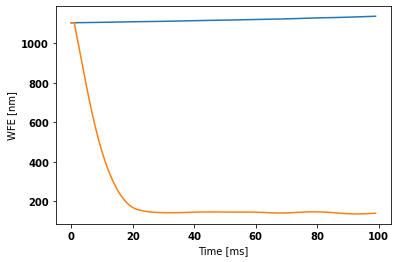

In [14]:
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)
